In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
import matplotlib.pyplot as plt

#import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
from matplotlib.ticker import FuncFormatter

In [4]:
formatter_tex_bps = FuncFormatter(lambda y, pos: "$%.0f$" % (10**4 * y))

def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0 \, y}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s \, y}$' % (str_x[:-2])

    return r'$\rm{%s \, y}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [5]:
def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s}$' % (str_x[:-2])

    return r'$\rm{%s}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [6]:
labelsize = 18
titlesize = 20

In [7]:
sys.path.append('..')

In [8]:
from finance.discountfactor import ConstantRateDiscountFactor
from finance.products.european.swap import SwapContract
from utils import time_offseter

loaded_data = None

with open('precomputed_sims/data1.pkl', 'rb') as f:
    loaded_data = dill.load(f)
    
step = 1 / 360.
delta = 5 * step

maturity = 5.0
print "Maturity = %s years" % maturity

R = 0.02
H = 0.1
discount = ConstantRateDiscountFactor(R)

udlyings = loaded_data["underlyings"]
print "Maximum number of paths: %i" % len(udlyings)

GBM0 = udlyings[0]
kappa = GBM0.drifts[0][0]
sigma = GBM0.vols[0][0]
print "kappa = %s, sigma = %s" % (kappa, sigma)

time_grid = GBM0.time

derivatives_nb = 1

swap_delta = 0.25
swap_dates = SwapContract.generate_payment_dates(0, maturity, swap_delta)
swap = SwapContract(GBM0, discount, swap_dates)

print swap

p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike * delta_beta_sum)

print "Notional on the swap: %s" % notional

copula = loaded_data["credit"]["copula"]
c_subsets_indexes = loaded_data["credit"]["bc_subsets_indexes"]
obligors_nb = len(copula.subsets[c_subsets_indexes[-1]][0])
print "Obligor numbers: %s" % obligors_nb

c_ids = [17, 9, 29, 26, 50, 4, 5, 13, 64]
c_positions = [0.69, -0.46, -0.44, -0.36, 0.34, 0.23, 0.09, -0.05, -0.04]

print "Counterparties id: %s (nb = %s)" % (c_ids, len(c_ids))

POSITIONS = np.zeros(obligors_nb)
for idx, ps in zip(c_ids, c_positions):
    POSITIONS[idx] = ps

POSITIONS = POSITIONS / -POSITIONS[13]
POSITIONS = np.array(POSITIONS).flatten()

print POSITIONS

spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
IDS_SPREADS = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))
IDS_POSITIONS = dict((id_, pos_) for (id_, pos_) in zip(c_ids, c_positions))

Maturity = 5.0 years
Maximum number of paths: 20000
kappa = 0.12, sigma = 0.2
Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Notional on the swap: 0.0015687485053
Obligor numbers: 125
Counterparties id: [17, 9, 29, 26, 50, 4, 5, 13, 64] (nb = 9)
[  0.    0.    0.    0.    4.6   1.8   0.    0.    0.   -9.2   0.    0.
   0.   -1.    0.    0.    0.   13.8   0.    0.    0.    0.    0.    0.
   0.    0.   -7.2   0.    0.   -8.8   0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    6.8   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.   -0.8   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    

In [9]:
QUANTIME_IM = 0.85
QUANTILE_ES = 0.99

RECOV = 0.4
S0 = GBM0(0.)[0, 0]

HURDLED_DISCOUNT = ConstantRateDiscountFactor(R + H)

LOIM_PATH = './res/aggregated/loss_over_im'
CVA_PATH = './res/aggregated/cva_ccp'

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [10]:
def fact_(swap_, discount_, kappa_, delta_, t_):
    time_grid_ = swap_.underlying.time
    t_delta_ = time_offseter(t_ + delta_, time_grid_, True)
    
    coupon_dates_ = swap_.pillars
    l_t_delta_ = np.searchsorted(coupon_dates_, t_delta_, side='left')

    beta_T_l_ = map(discount_, coupon_dates_[l_t_delta_ + 1 :])    
    h_l_ = swap_.delta_time[l_t_delta_ : ]
    
    T_l_m1_ = kappa_ * coupon_dates_[l_t_delta_ : -1]
    exp_factor_ = map(np.exp, T_l_m1_)
    
    tmp_ = np.multiply(exp_factor_, h_l_)    
    res_ = np.dot(beta_T_l_, tmp_)
    
    return res_

fact = partial(fact_, swap, discount, kappa, delta)

In [11]:
def B_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    
    var_ = vol_**2 * delta_
    exp_factor_ = np.exp(-0.5 * var_ + np.sqrt(var_) * q_)
    
    tmp_res_ = 1. - exp_factor_
    
    return np.sign(omega_) * tmp_res_ * fact_f_(t_)

B = partial(B_, fact, sigma, delta)

In [12]:
def C_(fact_f_, vol_, delta_, t_):
    x_ = 0.5 * vol_ * np.sqrt(delta_)
    fact_ = fact_f_(t_)
    
    cdf1 = norm.cdf(x_)
    cdf2 = norm.cdf(-x_)
    
    return fact_ * (cdf1 - cdf2)

C = partial(C_, fact, sigma, delta)

In [13]:
def A_(fact_f_, vol_, delta_, a_, omega_, t_):
    if a_ <= 0.5: 
        a_ = 1. - a_
    
    var_ = vol_**2 * delta_
    
    perc_ = a_ if omega_ <= 0. else (1. - a_)
    q_ = norm.ppf(perc_)
    sqrt_var_ = np.sqrt(var_)
    var_factor_ = np.exp(sqrt_var_ * q_)
    
    sgn_omega_ = np.sign(omega_)
    es_gauss_ = - norm.pdf(norm.ppf(a_)) / (1. - a_) * sgn_omega_
    es_factor_ = np.exp(sqrt_var_ * es_gauss_)
    
    diff_term_ = (var_factor_ - es_factor_) * sgn_omega_
    
    comm_factor_ = (1. - a_) * fact_f_(t_) * np.exp(-0.5 * var_)
    
    res_ = comm_factor_ * diff_term_
    return res_

A = partial(A_, fact, sigma, delta)

In [14]:
def compute_mva0_ul(q):
    mva0_ul = pd.Series(index=c_ids)

    for id_ in c_ids:
        pos_ = POSITIONS[id_]
        nom_i = np.abs(pos_) * notional

        factor = S0 * (1 - RECOV) * nom_i

        def integrand(t_):
            Bt_ = B(q, pos_, t_)
            gamma_t_ = copula.tot_gamma(t_, id_)
            surv_proba_t_ = copula.tot_survival_proba(t_, id_)

            return Bt_ * gamma_t_ * surv_proba_t_

        sub_indexes_ = copula.get_indexes_including(id_)
        int_pillars_ = set(copula.pillars[sub_indexes_].flatten())
        swap_pillars_ = set(swap.pillars)

        cut_times_ = list(int_pillars_ | swap_pillars_)
        cut_times_.sort()

        integral_ = 0.
        for t_i_, t_ip1_ in zip(cut_times_[:-1], cut_times_[1:]):
            x__ = np.linspace(t_i_, t_ip1_, 10)
            y__ = [integrand(x_i_) for x_i_ in x__]
            tmp_int__ = simps(y__, x__)
            integral_ += tmp_int__

        mva0 = factor * integral_
        mva0_ul[id_] = mva0
        
    return mva0_ul

In [15]:
def compute_mva0_sl(q):    
    mva0_sl = pd.Series(index=c_ids)

    for id_ in c_ids:
        pos_ = POSITIONS[id_]
        nom_i = np.abs(pos_) * notional

        factor = S0 * nom_i

        def integrand(t_):
            Ct_ = C(t_)
            A_i_t_ = A(q, pos_, t_)
            gamma_t_ = copula.tot_gamma(t_, id_)
            surv_proba_t_ = copula.tot_survival_proba(t_, id_)

            return (Ct_ - A_i_t_) * gamma_t_ * surv_proba_t_

        sub_indexes_ = copula.get_indexes_including(id_)
        int_pillars_ = set(copula.pillars[sub_indexes_].flatten())
        swap_pillars_ = set(swap.pillars)

        cut_times_ = list(int_pillars_ | swap_pillars_)
        cut_times_.sort()

        integral_ = 0.
        for t_i_, t_ip1_ in zip(cut_times_[:-1], cut_times_[1:]):
            x__ = np.linspace(t_i_, t_ip1_, 10)
            y__ = [integrand(x_i_) for x_i_ in x__]
            tmp_int__ = simps(y__, x__)
            integral_ += tmp_int__

        mva0 = factor * integral_
        mva0_sl[id_] = mva0
        
    return mva0_sl

In [16]:
def map_id_label(c_id_):
    pos_ = POSITIONS[c_id_]
    spread_ =  IDS_SPREADS[c_id_]
    
    pos_string_ = "%.2f" % abs(pos_)
    if pos_ > 0:
        pos_string_ = "(" + pos_string_ + ")"
    
    res = r'$%i \rm{bps}$''\n''$%s$' % (spread_, pos_string_)
    
    return res

In [17]:
spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]
ids_spreads = dict((id_, spread_) for (id_, spread_) in zip(c_ids, spreads))

sorted_bc_ids = sorted(ids_spreads.items(), key=lambda x: x[1])
sorted_bc_ids_spreads = [x[0] for x in sorted_bc_ids]

labels_spreads = map(map_id_label, sorted_bc_ids_spreads)

In [18]:
mva0_ul = pd.DataFrame(index=c_ids)

for quantile in [0.7, 0.8, 0.9, 0.975]:
    mva0_ul[quantile] = compute_mva0_ul(quantile)    
    
mva0_ul.index = mva0_ul.index.map(map_id_label)
mva0_ul.columns = mva0_ul.columns.map(lambda x: r'$%.1f \%%$' % (x * 100))

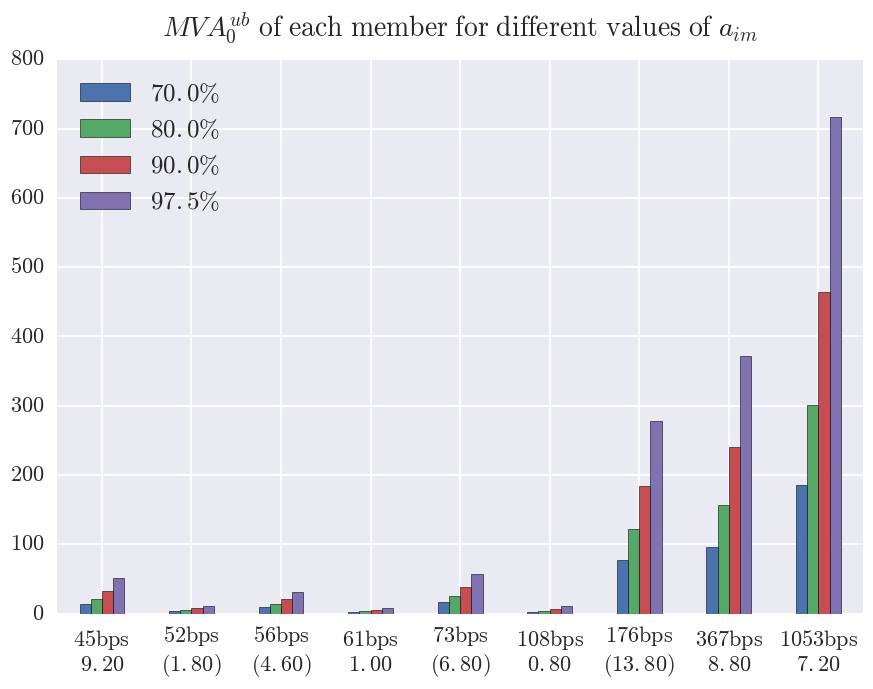

In [19]:
mva0_ul = mva0_ul.reindex(labels_spreads)

mva0_ul.plot.bar(rot=0)

formatter_pct = lambda x, pos: r'$%.0f$' % (x * 10000)
formatter_pct = FuncFormatter(formatter_pct)

plt.gca().yaxis.set_major_formatter(formatter_pct)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

plt.title(r'$MVA_0^{ub}\mathrm{\,\, of \,\, each \,\, member \,\, for \,\, different \,\, values \,\, of \,\,} a_{im}$', 
          y=1.03, 
          fontsize=titlesize)

plt.show()

In [20]:
mva0_sl = pd.DataFrame(index=c_ids)

for quantile in [0.7, 0.8, 0.9, 0.975]:
    mva0_sl[quantile] = compute_mva0_sl(quantile)    
    
mva0_sl.index = mva0_sl.index.map(map_id_label)
mva0_sl.columns = mva0_sl.columns.map(lambda x: r'$%.1f \%%$' % (x * 100))

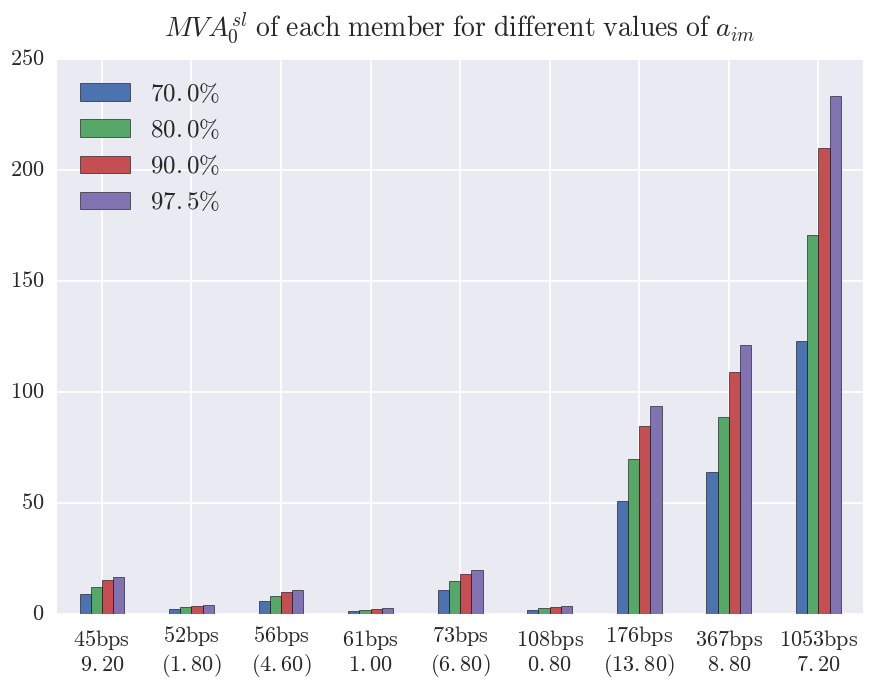

In [21]:
mva0_sl = mva0_sl.reindex(labels_spreads)

mva0_sl.plot.bar(rot=0)

formatter_pct = lambda x, pos: r'$%.0f$' % (x * 10000)
formatter_pct = FuncFormatter(formatter_pct)

plt.gca().yaxis.set_major_formatter(formatter_pct)

plt.legend(loc='best', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize-2)

plt.title(r'$MVA_0^{sl}\mathrm{\,\, of \,\, each \,\, member \,\, for \,\, different \,\, values \,\, of \,\,} a_{im}$', 
          y=1.03, 
          fontsize=titlesize)

plt.show()